### ETAのシミュレーション
自動運転車が道路を走る際、

Strategic（運行前計画） => Tactical（運行時の計画） => Ground（細かいセンシングなど）

の3つのフェーズがある。本研究では2つ目のTacticalフェーズにおける、車両の間隔制御を目的とする。まず、Strategicフェーズでは、だいたい何時頃に何台が到着するかがわかる。それを受けてTacticalフェーズでは実際に道路に到着した車に走路の事前予約（以下、CWP Reservation）を行わせ、その通りに運行する。このシミュレーションはCWP Reservationのアルゴリズムについての研究である。

ここでは大きく3つのオブジェクトが登場する

1. CWPTable: 予約管理をするテーブル
2. Car: 到着時刻に基づきCWPTableに希望時刻を打刻する。
3. Simulation: 帯域密度や到着間隔の管理を行う。

In [1]:
import random
import sys
sys.path.append("../../../")
from simulation_classes.eta.car import Cars
from simulation_classes.eta.CWPTable import CWPTable
from simulation_classes.eta.SimulationClass import ETASimulation
sys.path.append("../")
from utils import find_delta_v_list, find_delta_x_list

### パラメータ

- Global Density: 大域密度. 単位時間あたりの流入量
- Total_time_window: チケットを売っている時間の合計秒数
- window_size: チケット販売を分割する際の時間窓
- partition_num: チケット販売の分割数. 1だったら分割なしということ。

  ```Total_time_window = window_size * partition_num```
  が成立する。

In [2]:
# 初期設定（独立変数群）
CAR_NUM = 10 #時間窓内の車の総数
START_TIME = 0
TOTAL_LENGTH = 2000 # 入り口から出口までの距離 [m]
WAYPOINTS_NUM = 10 #constrained way pointの数
ORIFITH_LENGTH = 5 # 整流区間長さ. 最後のCWPのindexで指定。
MEAN_SPEED = 20 # 秒速[m/s]として定義
SCALE_FACTOR = 20 #シミュレーション上で距離を変換するための係数
TIME_STEP = 1
TOTAL_TIME = 100
V_MAX = 40

# ETAに関する設定
GLOBAL_TIME_WINDOW = 60  # Strategic Phaseでの時間幅
BATCH_NUM = 1
WINDOW_SIZE = (GLOBAL_TIME_WINDOW / BATCH_NUM)
DESIRED_TTC = 5 # 目標とする車間時間 [s]
DESIRED_SPEED = 21 # 目標とする出口速度 [m/s]

# 車のパラメータ
MAX_ACC_REAL_WORLD = 2 # 0.2Gくらい
MIN_ACC_REAL_WORLD = 2 # 0.5Gくらい
FRONT_BRAKE_REAL_WORLD = 8 # 0.8Gくらい

helly_params = {
    "max_accel":  MAX_ACC_REAL_WORLD,
    "min_accel": 2,
    "front_car_brake":FRONT_BRAKE_REAL_WORLD / SCALE_FACTOR,
    "rear_brake_acc":2,
    "response_time":0.5, #秒で入れる,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1.1,
    "isRss":False
  }
rss_params = {
    "max_accel":  MAX_ACC_REAL_WORLD,
    "min_accel": 2,
    "front_car_brake":FRONT_BRAKE_REAL_WORLD / SCALE_FACTOR,
    "rear_brake_acc":2,
    "response_time":0.5, 
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1.1,
    "isRss":True,
  }

simulation_params = {"TOTAL_TIME": TOTAL_TIME, "TIME_STEP":TIME_STEP}

In [3]:
# 従属的に決まるもの
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
group_id = 0

arrival_times = sorted([random.uniform(0, GLOBAL_TIME_WINDOW) for _ in range(CAR_NUM)])
# arrival_times = [15.3, 27.1, 48.66, 54.83, 55.63]
CARS = [Cars(arrival_time=time, index=index, mean_speed=MEAN_SPEED, \
              helly_params=helly_params, group_id=group_id, order_in_group=index)
              for index, time in enumerate(arrival_times)]

In [4]:
# ETA割り当てのアルゴリズム
"""
KISS: 基本的には車のdesiredに合わせる、最初のWaypointからTTCの分だけ空ける
CONTROLLED: 全体最適になるように調整
"""
ALGORITHM_LIST = ["KISS", "CONTROLLED", ]
ALGORITHM = ALGORITHM_LIST[1]

cwp_table_controlled = CWPTable(waypoints = WAYPOINTS, algorithm = ALGORITHM_LIST[1], \
                     global_params={"WINDOW_SIZE":WINDOW_SIZE, "START_TIME":START_TIME, "DESIRED_TTC":DESIRED_TTC, \
                                   "ORIFITH_EXIT_INDEX":ORIFITH_LENGTH, "DESIRED_SPEED": DESIRED_SPEED, "V_MAX":V_MAX})

cwp_table_kiss = CWPTable(waypoints = WAYPOINTS, algorithm = ALGORITHM_LIST[0], \
                     global_params={"WINDOW_SIZE":WINDOW_SIZE, "START_TIME":START_TIME, "DESIRED_TTC":DESIRED_TTC, \
                                   "ORIFITH_EXIT_INDEX":ORIFITH_LENGTH, "DESIRED_SPEED": DESIRED_SPEED, "V_MAX":V_MAX})

60.0
60.0


In [5]:
eta_simulation_controlled = ETASimulation(CARS=CARS, CWPTable=cwp_table_controlled, simulation_params=simulation_params)
eta_simulation_simpler = ETASimulation(CARS=CARS, CWPTable=cwp_table_kiss, simulation_params=simulation_params)


In [6]:
# eta_simulation_controlled.conduct_simulation()
eta_simulation_simpler.conduct_simulation()
cwp_table_simpler = eta_simulation_simpler.cwp_table
# cwp_table_simpler.plot()

eta_simulation_controlled.conduct_simulation()
cwp_table_controlled = eta_simulation_controlled.cwp_table

idx=0, エントランス到着時刻=1.4186905361839908
初回
idx=1, エントランス到着時刻=15.563151944543565
idx=2, エントランス到着時刻=19.63727620427771
idx=3, エントランス到着時刻=20.092888549564346
idx=4, エントランス到着時刻=31.671290095711463
idx=5, エントランス到着時刻=34.44483726935225
idx=6, エントランス到着時刻=43.1695612174461
idx=7, エントランス到着時刻=45.79278871301739
idx=8, エントランス到着時刻=48.67153903103174
idx=9, エントランス到着時刻=55.47326375095382
idx=0, エントランス到着時刻=1.4186905361839908
理想到着時刻 47.61904761904762
{'is_possible': True, 'Reason': 'OK'}
出口到達時刻:  47.64642457244128

idx=1, エントランス到着時刻=15.563151944543565
理想到着時刻 52.64642457244128
{'is_possible': True, 'Reason': 'OK'}
出口到達時刻:  52.64645230085592

idx=2, エントランス到着時刻=19.63727620427771
理想到着時刻 57.64645230085592
{'is_possible': True, 'Reason': 'OK'}
出口到達時刻:  57.642016970858094

idx=3, エントランス到着時刻=20.092888549564346
理想到着時刻 62.642016970858094
{'is_possible': True, 'Reason': 'OK'}
出口到達時刻:  62.6482642708318

idx=4, エントランス到着時刻=31.671290095711463
理想到着時刻 67.6482642708318
{'is_possible': True, 'Reason': 'OK'}
出口到達時刻:  67.65637501619

    waypoint_idx       x         eta  car_idx  group_id  order_in_group
0              0     0.0    1.418691        0         0               0
1              1   200.0   10.688232        0         0               0
2              2   400.0   19.926357        0         0               0
3              3   600.0   29.164483        0         0               0
4              4   800.0   38.402608        0         0               0
..           ...     ...         ...      ...       ...             ...
6              6  1200.0  102.199461        9         0               9
7              7  1400.0  111.723271        9         0               9
8              8  1600.0  121.247080        9         0               9
9              9  1800.0  130.770890        9         0               9
10            10  2000.0  140.294699        9         0               9

[110 rows x 6 columns]


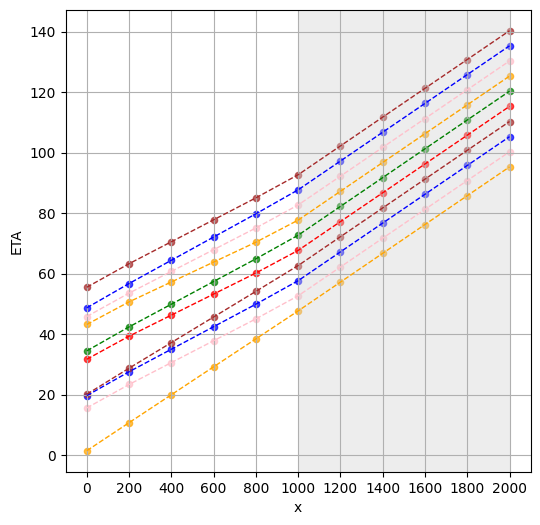

In [7]:
# cwp_table_controlled.plot()
# cwp_table_simpler.plot()
print(cwp_table_controlled.waypoint_table)
cwp_table_controlled.plot()

In [9]:
print(eta_simulation_controlled.calc_rectification())
print(eta_simulation_simpler.calc_rectification())

0.0017582581039695853
0.646779246196563


[{'ACC': 0, 'duration': 14.158084199964131, 'initial_speed': 20}, {'ACC': 2, 'duration': 2.5, 'initial_speed': 20}, {'ACC': 0, 'duration': 26.42380025283719, 'initial_speed': 25}]


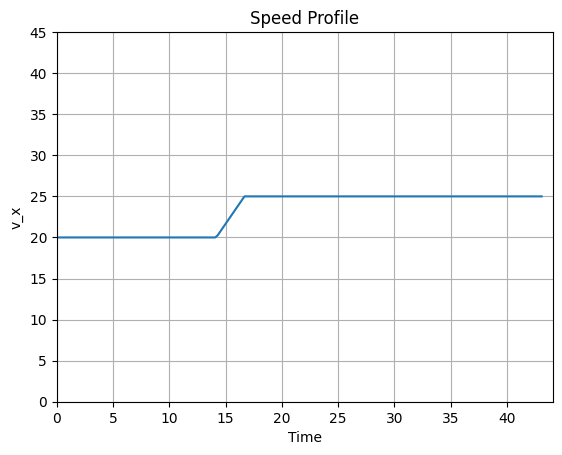

In [9]:
profile = CARS[7].speed_profile
print(profile)
CARS[7].plot_speed_profile()

In [11]:
profile = CARS[3].speed_profile
print(profile)
# CARS[3].plot_speed_profile()

[{'ACC': 0, 'duration': 28.729703548847652, 'initial_speed': 20}, {'ACC': 2, 'duration': 2.5, 'initial_speed': 20}, {'ACC': 0, 'duration': 14.765719011152342, 'initial_speed': 25}]


In [10]:
df = cwp_table.waypoint_table
print(df[df['car_idx'] == 2])


    waypoint_idx       x         eta  car_idx  group_id  order_in_group
0              0     0.0   48.660000        2         0               2
1              1   200.0   55.980508        2         0               2
2              2   400.0   71.825423        2         0               2
3              3   600.0   79.825423        2         0               2
4              4   800.0   87.825423        2         0               2
5              5  1000.0   95.825423        2         0               2
6              6  1200.0  103.825423        2         0               2
7              7  1400.0  111.825423        2         0               2
8              8  1600.0  119.825423        2         0               2
9              9  1800.0  127.825423        2         0               2
10            10  2000.0  135.825423        2         0               2


In [1]:
cwp_table_controlled = cwp_table

NameError: name 'cwp_table' is not defined

In [75]:
cwp_table_kiss = cwp_table


In [7]:
# cwp_table.waypoint_table
df = cwp_table.waypoint_table
df[(df["group_id"] == 0) & (df["order_in_group"] == 0) & (df["waypoint_idx"] == 5)]["eta"].iloc[0]

40.016804311934614